# Consignes

- Construisez deux modèles un SVM et un Naive bayesien en normalisant ou standardisant vos vairiables explicatives.
    - utilisez gridsearch pour obtenir les meileurs paramètres et tracer les validations curves pour les différents paramètrs
- Utilisez polynomial feature pour tenter d'améliorer vos deux modèles 
- Vérifier que vos meilleurs modèles n'overfittent pas.

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, roc_auc_score,plot_roc_curve, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np
import shap

In [5]:
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

In [6]:
df = pd.read_csv("data/intermediate/Telco_post_analysis.csv")

## Préparation à la standardisation

In [7]:
df["Churn"] = LabelEncoder().fit_transform(df["Churn"])
for col in df.drop("customerID",axis=1).columns:
    df[col][(df[col]=="No") | (df[col]=="Male") | (df[col]=="DSL") | (df[col]=="Only Internet")] = 0
    df[col][(df[col]=="Yes") | (df[col]=="Female") | (df[col]=="Fiber optic") | (df[col]=="Phone and Internet")] = 1
    df[col][(df[col]=="No phone service") | (df[col]=="No internet service") | (df[col]=="Only Phone")] = -1
    df[col][df[col] == "Month-to-month"] = 1
    df[col][df[col] == "One year"] = 12
    df[col][df[col] == "Two year"] = 24
    df[col][df[col] == "Mailed check"] = 0
    df[col][df[col] == "Electronic check"] = 1
    df[col][df[col] == "Credit card (automatic)"] = 2
    df[col][df[col] == "Bank transfer (automatic)"] = 3
    df[col] = df[col].astype(float)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

## Pipelines

In [8]:
features_standard = df.drop(["customerID","Churn"], axis=1).columns
standard_pipeline = make_pipeline(StandardScaler())

preprocessor = make_column_transformer((standard_pipeline,features_standard))

In [72]:
nv = make_pipeline(preprocessor, GaussianNB(priors=[0.8,0.2]))
svm = make_pipeline(preprocessor, SVC(random_state=1, probability=True, class_weight={0:1, 1:4}, kernel="linear", C= 0.01))

## Modéles

In [10]:
X = df.drop(["customerID", "Churn"], axis=1)
y = df.Churn

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

In [12]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, roc_auc_score  

In [13]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    return accuracy, f1, recall, precision

2022/03/02 16:10:04 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index([...`
2022/03/02 16:10:04 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['gender', 'SeniorCitize...`
2022/03/02 16:10:04 WARNING mlflow.utils: Truncated the value of the key `columntransformer__transformers`. Truncated value: `[('pipeline', Pipeline(steps=[('standardscaler', StandardScaler())]), Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneServic

  accuracy: 0.7668798862828714
  f1: 0.6229885057471264
  recall: 0.7404371584699454
  precision: 0.5376984126984127
ROC = 0.8202167419935644


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


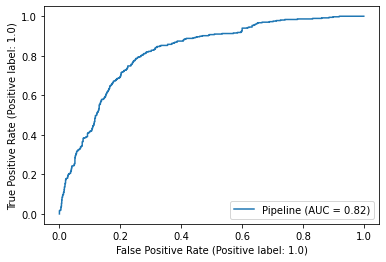

In [76]:
mlflow.sklearn.autolog()

with mlflow.start_run(experiment_id = 1):
    model = nv.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= 0.8).astype(bool) # seuil
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy, f1, recall, precision = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision) 
    
    print(f'ROC = {roc_auc_score(y_test, y_pred_proba[:,1])}')
    
    mlflow.log_param("Variables", X_test.columns)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="Naive Bayes")
    else:
        mlflow.sklearn.log_model(model, "model") 

plot_roc_curve(model, X_test, y_test)

In [45]:
confusion_matrix(y_test, y_pred)

array([[714, 327],
       [ 61, 305]], dtype=int64)

In [ ]:
X_sample = shap.utils.sample(X_train)
explainer = shap.Explainer(model.predict, X_sample)
shap_values = explainer(X_train)

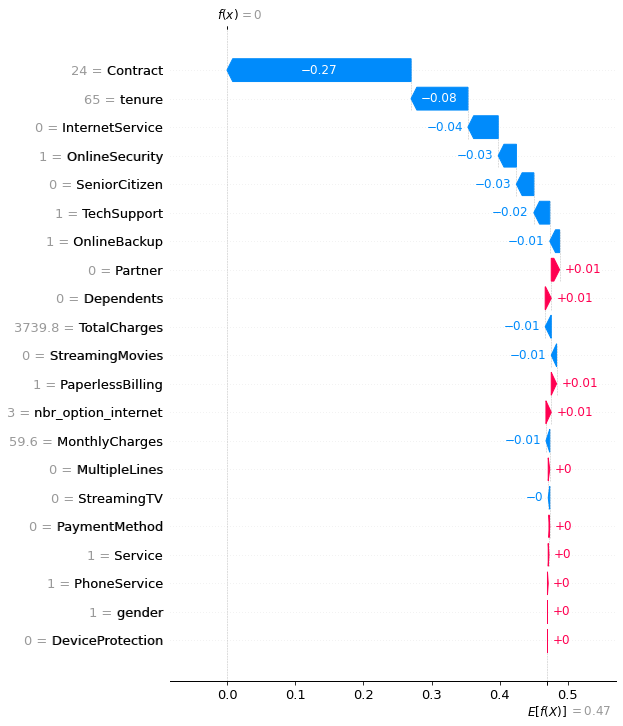

In [41]:
shap.plots.waterfall(shap_values[18], max_display=22)

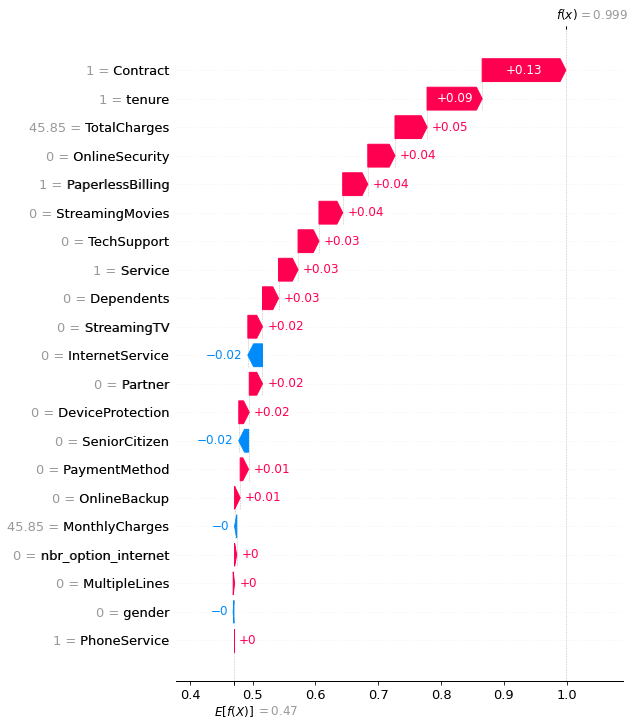

In [38]:
shap.plots.waterfall(shap_values[4], max_display=22)

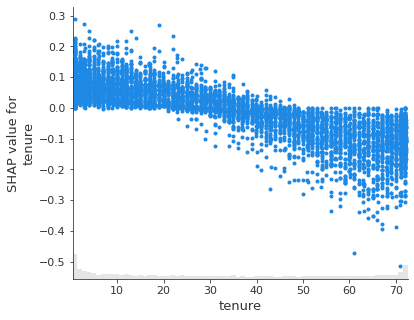

In [83]:
shap.plots.scatter(shap_values[:,"tenure"])

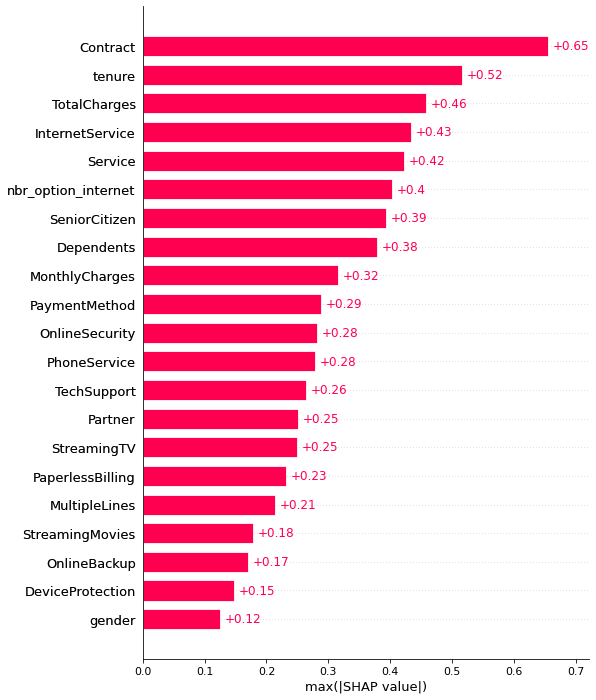

In [86]:
shap.plots.bar(shap_values.abs.max(0), max_display=22)

Ces graphiques illustrent l'augmentation ou la diminution de la probabilité de "churner" avec l'ajout de chaque features pour la ligne 18 et 4 du dataset après permutations des valeurs des features.

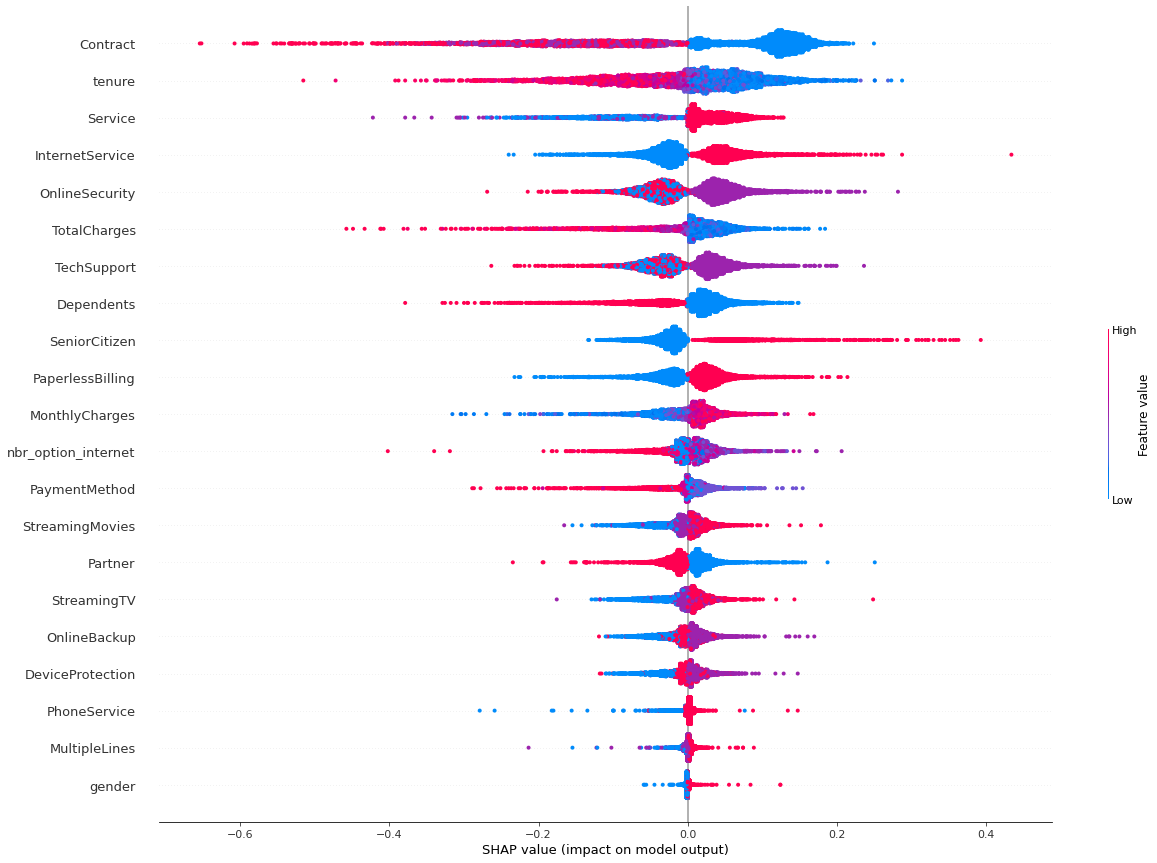

In [39]:
shap.plots.beeswarm(shap_values, max_display=22, plot_size=(20,15))

2022/03/02 15:24:12 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index([...`
2022/03/02 15:24:12 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['gender', 'SeniorCitize...`
2022/03/02 15:24:12 WARNING mlflow.utils: Truncated the value of the key `columntransformer__transformers`. Truncated value: `[('pipeline', Pipeline(steps=[('standardscaler', StandardScaler())]), Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneServic

  accuracy: 0.798862828713575
  f1: 0.6180836707152496
  recall: 0.6256830601092896
  precision: 0.6106666666666667
ROC = 0.8450037532217342


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


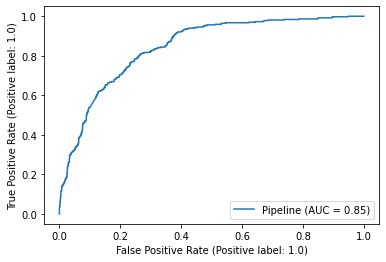

In [31]:
with mlflow.start_run(experiment_id = 1):
    model = svm.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= 0.48).astype(bool)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy, f1, recall, precision = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision)  

    print(f'ROC = {roc_auc_score(y_test, y_pred_proba[:,1])}')
    mlflow.log_param("Variables", X_test.columns)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="SVM")
    else:
        mlflow.sklearn.log_model(model, "model") 

plot_roc_curve(model, X_test, y_test)

In [42]:
confusion_matrix(y_test, y_pred)

array([[895, 146],
       [137, 229]], dtype=int64)